## Import Modules

In [1]:
import pandas as pd
import numpy as np
import os, random, codecs, json, pickle
seed = 99
random.seed(seed)
np.random.seed(seed)
from collections import Counter

from ast import literal_eval
from pprint import pprint
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import gensim.test.utils 
import bitermplus
import tqdm
import itertools

%matplotlib inline
import matplotlib.pyplot as plt
from pyvis.network import Network

import tomotopy as tp
from tomotopy.utils import Corpus
import tmplot as tmp
import altair
import ipywidgets

from imp import reload
import pyLDAvis
import pyLDAvis.gensim_models
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [ ]:
print(tp.isa)

## Text Cleaning

In [2]:
#read the dataframe
kremlin = pd.read_excel('data/putin_corpus.xlsx')
kremlin.rename(columns = {'p':'text'}, inplace = True)
kremlin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33189 entries, 0 to 33188
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          33189 non-null  object
 1   URL           33189 non-null  object
 2   description   30316 non-null  object
 3   introduction  30316 non-null  object
 4   id            33189 non-null  int64 
 5   speaker       33189 non-null  object
 6   text          33189 non-null  object
dtypes: int64(1), object(6)
memory usage: 1.8+ MB


In [4]:
kremlin.head()

date                                            URL  \
0  2012-05-07  http://kremlin.ru/events/president/news/15224   
1  2012-05-07  http://kremlin.ru/events/president/news/15224   
2  2012-05-07  http://kremlin.ru/events/president/news/15224   
3  2012-05-07  http://kremlin.ru/events/president/news/15224   
4  2012-05-07  http://kremlin.ru/events/president/news/15224   

                                         description  \
0  –í –ë–æ–ª—å—à–æ–º –ö—Ä–µ–º–ª—ë–≤—Å–∫–æ–º –¥–≤–æ—Ä—Ü–µ —Å–æ—Å—Ç–æ—è–ª–∞—Å—å —Ç–æ—Ä–∂–µ—Å...   
1  –í –ë–æ–ª—å—à–æ–º –ö—Ä–µ–º–ª—ë–≤—Å–∫–æ–º –¥–≤–æ—Ä—Ü–µ —Å–æ—Å—Ç–æ—è–ª–∞—Å—å —Ç–æ—Ä–∂–µ—Å...   
2  –í –ë–æ–ª—å—à–æ–º –ö—Ä–µ–º–ª—ë–≤—Å–∫–æ–º –¥–≤–æ—Ä—Ü–µ —Å–æ—Å—Ç–æ—è–ª–∞—Å—å —Ç–æ—Ä–∂–µ—Å...   
3  –í –ë–æ–ª—å—à–æ–º –ö—Ä–µ–º–ª—ë–≤—Å–∫–æ–º –¥–≤–æ—Ä—Ü–µ —Å–æ—Å—Ç–æ—è–ª–∞—Å—å —Ç–æ—Ä–∂–µ—Å...   
4  –í –ë–æ–ª—å—à–æ–º –ö—Ä–µ–º–ª—ë–≤—Å–∫–æ–º –¥–≤–æ—Ä—Ü–µ —Å–æ—Å—Ç–æ—è–ª–∞—Å—å —Ç–æ—Ä–∂–µ—Å...   

                                        introduction  id     speaker  \
0  –í –ë–æ–ª—å—à–æ–º –ö—Ä–µ–º–ª—ë–≤—Å–∫–æ–º –¥–≤–æ—Ä—Ü–µ —Å–æ—Å—Ç–æ—è–ª–∞—Å—å —Ç–æ—Ä–∂–µ—Å...   1  –î.–ú–µ–¥–≤–µ–¥–µ–≤   
1  –í –ë–æ–ª—å—à–æ–º –ö—Ä–µ–º–ª—ë–≤—Å–∫–æ–º –¥–≤–æ—Ä—Ü–µ —Å–æ—Å—Ç–æ—è–ª–∞—Å—å —Ç–æ—Ä–∂–µ—Å...   2  –î.–ú–µ–¥–≤–µ–¥–µ–≤   
2  –í –ë–æ–ª—å—à–æ–º –ö—Ä–µ–º–ª—ë–≤—Å–∫–æ–º –¥–≤–æ—Ä—Ü–µ —Å–æ—Å—Ç–æ—è–ª–∞—Å—å —Ç–æ—Ä–∂–µ—Å...   3  –î.–ú–µ–¥–≤–µ–¥–µ–≤   
3  –í –ë–æ–ª—å—à–æ–º –ö—Ä–µ–º–ª—ë–≤—Å–∫–æ–º –¥–≤–æ—Ä—Ü–µ —Å–æ—Å—Ç–æ—è–ª–∞—Å—å —Ç–æ—Ä–∂–µ—Å...   4  –î.–ú–µ–¥–≤–µ–¥–µ–≤   
4  –í –ë–æ–ª—å—à–æ–º –ö—Ä–µ–º–ª—ë–≤—Å–∫–æ–º –¥–≤–æ—Ä—Ü–µ —Å–æ—Å—Ç–æ—è–ª–∞—Å—å —Ç–æ—Ä–∂–µ—Å...   5  –î.–ú–µ–¥–≤–µ–¥–µ–≤   

                                                text  
0         –£–≤–∞–∂–∞–µ–º—ã–µ –≥—Ä–∞–∂–¥–∞–Ω–µ –†–æ—Å—Å–∏–∏! –î–æ—Ä–æ–≥–∏–µ –¥—Ä—É–∑—å—è!  
1  –í—Å—Ç—É–ø–ª–µ–Ω–∏–µ –∏–∑–±—Ä–∞–Ω–Ω–æ–≥–æ –ü—Ä–µ–∑–∏–¥–µ–Ω—Ç–∞ –≤ –¥–æ–ª–∂–Ω–æ—Å—Ç—å ‚Äì...  
2  –ü–æ—Å–ª–µ–¥–æ–≤–∞—Ç–µ–ª—å–Ω–æ—Å—Ç—å –≥–æ—Å—É–¥–∞—Ä—Å—Ç–≤–µ–Ω–Ω–æ–≥–æ –∫—É—Ä—Å–∞ ‚Äì —ç—Ç...  
3  –ò–º–µ–Ω–Ω–æ —ç—Ç–∏ –∑–∞–¥–∞—á–∏ –±—ã–ª–∏ –ø—Ä–∏–æ—Ä–∏—Ç–µ—Ç–Ω—ã–º–∏ –¥–ª—è –º–µ–Ω—è ...  
4  –ù–∞–º –º–Ω–æ–≥–æ–µ —É–¥–∞–ª–æ—Å—å ‚Äì –¥–∞–∂–µ –≤ –Ω–µ–ø—Ä–æ—Å—Ç–æ–π –ø–µ—Ä–∏–æ–¥ –≥...

In [3]:
kremlin['date']

0        2012-05-07
1        2012-05-07
2        2012-05-07
3        2012-05-07
4        2012-05-07
            ...    
33184    2022-08-16
33185    2022-08-16
33186    2022-08-16
33187    2022-08-16
33188    2022-08-16
Name: date, Length: 33189, dtype: object

In [ ]:
# words like –ù–ê–¢–û and –ï–≤—Ä–æ—Å–æ—é–∑ are in the dataset
kremlin[kremlin['text'].str.contains('–ï–≤—Ä–æ—Å–æ—é–∑')]

In [ ]:
#delete entries with less than 15 words (mostly greetings)
kremlin['word_count'] = kremlin['text'].str.split().str.len()
kremlin['word_count'].sort_values(ascending=False)


In [ ]:
short_text = kremlin[kremlin['word_count'] < 15]

In [ ]:
short_text[short_text['text'].str.contains('–ï–≤—Ä–æ—Å–æ—é–∑')]

In [ ]:
df = kremlin[kremlin['word_count'] > 15].reset_index(drop=True)

In [ ]:
df[df['text'].str.contains('–ï–≤—Ä–æ—Å–æ—é–∑')].sort_values(by= 'word_count', ascending=False).head()

In [ ]:
#Identify Noise with Regular Expression
import re 
RE_SUSPICIOUS = re.compile(r'[√Ñ√¥&#<>{}\[\]\\]')

def impurity(text, min_len=10): 
    """returns the share of suspicious characters in a text""" 
    if text == None or len(text) < min_len: 
        return 0 
    else: 
        return len(RE_SUSPICIOUS.findall(text))/len(text)

In [ ]:
# add new column to data frame
df['impurity'] = df['text'].apply(impurity, min_len=10)
df['impurity'].sort_values().value_counts()

In [ ]:
# get the top 3 records 
#critical part is just []...I will leave as it is for the moment
df[['text', 'impurity']].sort_values(by='impurity', ascending=False).head(3)

In [ ]:
#create a function to clean the text
def clean(text):
     # everything non-alpahnumeric with a space
     text = re.sub(r'\W+',' ', text)
     # Two or more dots with one
     text = re.sub(r'\.{2,}', ' ', text)
     # this code made several words to disappear
     #convert text to lowercase             
     text = text.lower()
     #match all digits
     text = re.sub(r'\d+',' ', text)
     # sequences of white spaces
     text = re.sub(r'\s+', ' ', text) 
     return text.strip()

In [ ]:
#apply the function
df['text'] = df['text'].map(clean)

In [ ]:
# get the top 3 records 
#critical part is just []...I will leave as it is for the moment
df[['text', 'impurity']].sort_values(by='impurity', ascending=False).head(3)

In [ ]:
df.drop(columns=['impurity'], inplace=True)

In [ ]:
df[df['text'].str.contains('–µ–≤—Ä–æ—Å–æ—é–∑')]

## Text Preprocessing

In [ ]:
import spacy
from spacy.tokenizer import Tokenizer
from spacy.lang.ru.stop_words import STOP_WORDS

In [ ]:
nlp_spacy = spacy.load('ru_core_news_sm', exclude=["ner"])
nlp_spacy.disable_pipe("parser")
nlp_spacy.enable_pipe("senter")

In [ ]:
#let‚Äôs build phrase models that we can clean and use to create the corpus for our analysis
bigram = gensim.models.Phrases(df['text'], min_count = 5,
                               threshold = 100)

In [ ]:
bigram_mod = gensim.models.phrases.Phraser(bigram)

In [ ]:
#Customise Stopwords
from spacy.lang.ru import stop_words
nlp_spacy.Defaults.stop_words |= {'–¥–µ–ª–∞—Ç—å', '–¥–µ–Ω—å', '–¥–æ—Ä–æ–≥–æ–π','–¥—É–º–∞—Ç—å', '–¥–æ–±—Ä—ã–π', '–¥–≤–∞', '–∫–æ–ª–ª–µ–≥–∞','–∑–Ω–∞—Ç—å','–≥–æ–¥','–≥–æ—Å–ø–æ–¥–∏–Ω','–º–∏–ª–ª–∏–∞—Ä–¥', '–Ω–æ–≤—ã–π',
                                    '—Ä–∞–∑', '–Ω–∏', '–ø–æ–Ω–∏–º–∞—Ç—å','–ø—Ä–µ–∑–∏–¥–µ–Ω—Ç','–ø—Ä–æ—Ü–µ–Ω—Ç','–ø—É—Ç–∏–Ω', '—Å–µ–≥–æ–¥–Ω—è','—Å–ª–æ–≤–æ','—Å–ø–∞—Å–∏–±–æ', '—É–≤–∞–∂–∞–µ–º—ã–π', '—É–≤–∞–∂–∞–µ–º—ãe','–≤–ª–∞–¥–∏–º–∏—Ä','–≤–ª–∞–¥–∏–º–∏—Ä–æ–≤–∏—á', '–≤–∏–¥–µ—Ç—å','—Ö–æ—Ç–µ—Ç—å'}
stop_words = stop_words.STOP_WORDS
#custom_stop_words = [word for word in nlp_spacy.Defaults.stop_words if word not in ["e–≤—Ä–æ—Å–æ—é–∑", "–Ω–∞—Ç–æ"]]

In [ ]:
lemma = []
#Turn words into lemmas
for doc in nlp_spacy.pipe(df['text'].astype('unicode').values, batch_size=50):
    lemma.append([n.lemma_.lower() for n in doc
                if n.lemma_.lower() not in stop_words])

df['lemma'] = lemma

In [ ]:
df[df['text'].str.contains('–µ–≤—Ä–æ—Å–æ—é–∑')]

In [ ]:
df.to_pickle('data/df_lemma.pkl')

### Read saved lemma corpus

In [10]:
#read and transform the preprocessed data in a list
read_lemma = pd.read_pickle('data/df_lemma.pkl')
data_lemma = read_lemma['lemma'].tolist()

In [3]:
read_lemma[read_lemma['text'].str.contains('–Ω–∞—Ç–æ')]

date                                                URL  \
12     2012-05-07      http://kremlin.ru/events/president/news/15224   
120    2012-05-26      http://kremlin.ru/events/president/news/15445   
132    2012-05-26      http://kremlin.ru/events/president/news/15445   
133    2012-05-26      http://kremlin.ru/events/president/news/15445   
240    2012-06-15  http://kremlin.ru/events/president/transcripts...   
...           ...                                                ...   
25681  2022-06-18      http://kremlin.ru/events/president/news/68673   
25768  2022-06-18      http://kremlin.ru/events/president/news/68673   
25874  2022-06-30      http://kremlin.ru/events/president/news/68790   
25923  2022-08-16      http://kremlin.ru/events/president/news/69166   
25928  2022-08-16      http://kremlin.ru/events/president/news/69166   

                                             description  \
12     –í –ë–æ–ª—å—à–æ–º –ö—Ä–µ–º–ª—ë–≤—Å–∫–æ–º –¥–≤–æ—Ä—Ü–µ —Å–æ—Å—Ç–æ—è–ª–∞—Å—å —Ç–æ—Ä–∂–µ—Å...   
120    –£—á–∞—Å—Ç–Ω–∏–∫–∏ —Å—ä–µ–∑–¥–∞ –µ–¥–∏–Ω–æ–≥–ª–∞—Å–Ω–æ –∏–∑–±—Ä–∞–ª–∏ –Ω–∞ –ø–æ—Å—Ç –ø...   
132    –£—á–∞—Å—Ç–Ω–∏–∫–∏ —Å—ä–µ–∑–¥–∞ –µ–¥–∏–Ω–æ–≥–ª–∞—Å–Ω–æ –∏–∑–±—Ä–∞–ª–∏ –Ω–∞ –ø–æ—Å—Ç –ø...   
133    –£—á–∞—Å—Ç–Ω–∏–∫–∏ —Å—ä–µ–∑–¥–∞ –µ–¥–∏–Ω–æ–≥–ª–∞—Å–Ω–æ –∏–∑–±—Ä–∞–ª–∏ –Ω–∞ –ø–æ—Å—Ç –ø...   
240                                                  NaN   
...                                                  ...   
25681  –ù–∞–∫–∞–Ω—É–Ω–µ –î–Ω—è –º–µ–¥–∏—Ü–∏–Ω—Å–∫–æ–≥–æ —Ä–∞–±–æ—Ç–Ω–∏–∫–∞ –í–ª–∞–¥–∏–º–∏—Ä –ü...   
25768  –ù–∞–∫–∞–Ω—É–Ω–µ –î–Ω—è –º–µ–¥–∏—Ü–∏–Ω—Å–∫–æ–≥–æ —Ä–∞–±–æ—Ç–Ω–∏–∫–∞ –í–ª–∞–¥–∏–º–∏—Ä –ü...   
25874  –ì–ª–∞–≤–∞ –≥–æ—Å—É–¥–∞—Ä—Å—Ç–≤–∞ –≤–æ–∑–ª–æ–∂–∏–ª —Ü–≤–µ—Ç—ã –∫ –ø–æ–¥–Ω–æ–∂–∏—é –º–æ...   
25923                                                NaN   
25928                                                NaN   

                                            introduction   id     speaker  \
12     –í –ë–æ–ª—å—à–æ–º –ö—Ä–µ–º–ª—ë–≤—Å–∫–æ–º –¥–≤–æ—Ä—Ü–µ —Å–æ—Å—Ç–æ—è–ª–∞—Å—å —Ç–æ—Ä–∂–µ—Å...   19     –í.–ü—É—Ç–∏–Ω   
120    –£—á–∞—Å—Ç–Ω–∏–∫–∏ —Å—ä–µ–∑–¥–∞ –µ–¥–∏–Ω–æ–≥–ª–∞—Å–Ω–æ –∏–∑–±—Ä–∞–ª–∏ –Ω–∞ –ø–æ—Å—Ç –ø...    9     –í.–ü—É—Ç–∏–Ω   
132    –£—á–∞—Å—Ç–Ω–∏–∫–∏ —Å—ä–µ–∑–¥–∞ –µ–¥–∏–Ω–æ–≥–ª–∞—Å–Ω–æ –∏–∑–±—Ä–∞–ª–∏ –Ω–∞ –ø–æ—Å—Ç –ø...   21     –í.–ü—É—Ç–∏–Ω   
133    –£—á–∞—Å—Ç–Ω–∏–∫–∏ —Å—ä–µ–∑–¥–∞ –µ–¥–∏–Ω–æ–≥–ª–∞—Å–Ω–æ –∏–∑–±—Ä–∞–ª–∏ –Ω–∞ –ø–æ—Å—Ç –ø...   22     –í.–ü—É—Ç–∏–Ω   
240                                                  NaN    6     –í.–ü—É—Ç–∏–Ω   
...                                                  ...  ...         ...   
25681  –ù–∞–∫–∞–Ω—É–Ω–µ –î–Ω—è –º–µ–¥–∏—Ü–∏–Ω—Å–∫–æ–≥–æ —Ä–∞–±–æ—Ç–Ω–∏–∫–∞ –í–ª–∞–¥–∏–º–∏—Ä –ü...   76     –ê.–ü–æ–ø–æ–≤   
25768  –ù–∞–∫–∞–Ω—É–Ω–µ –î–Ω—è –º–µ–¥–∏—Ü–∏–Ω—Å–∫–æ–≥–æ —Ä–∞–±–æ—Ç–Ω–∏–∫–∞ –í–ª–∞–¥–∏–º–∏—Ä –ü...  285   –ú.–ú—É—Ä–∞—à–∫–æ   
25874  –ì–ª–∞–≤–∞ –≥–æ—Å—É–¥–∞—Ä—Å—Ç–≤–∞ –≤–æ–∑–ª–æ–∂–∏–ª —Ü–≤–µ—Ç—ã –∫ –ø–æ–¥–Ω–æ–∂–∏—é –º–æ...   27  –°.–ù–∞—Ä—ã—à–∫–∏–Ω   
25923                                                NaN    7     –í.–ü—É—Ç–∏–Ω   
25928                                                NaN   12     –í.–ü—É—Ç–∏–Ω   

                                                    text  word_count  \
12     –º—ã –≤–º–µ—Å—Ç–µ –ø—Ä–æ—à–ª–∏ –±–æ–ª—å—à–æ–π –∏ —Å–ª–æ–∂–Ω—ã–π –ø—É—Ç—å –ø–æ–≤–µ—Ä–∏...         100   
120    –ø–æ—ç—Ç–æ–º—É —Å—á–∏—Ç–∞—é –ø—Ä–∞–≤–∏–ª—å–Ω—ã–º —á—Ç–æ–±—ã –≤–æ –≥–ª–∞–≤–µ –ø–∞—Ä—Ç–∏...          50   
132    –ø—Ä–µ–¥–ª–∞–≥–∞—é —Å—ä–µ–∑–¥—É –ø–∞—Ä—Ç–∏–∏ –∫–∞–Ω–¥–∏–¥–∞—Ç—É—Ä—É –¥–º–∏—Ç—Ä–∏—è –∞–Ω...          22   
133    –ø—Ä–µ–∂–¥–µ –≤—Å–µ–≥–æ —Ö–æ—á—É –ø–æ–∑–¥—Ä–∞–≤–∏—Ç—å –¥–º–∏—Ç—Ä–∏—è –∞–Ω–∞—Ç–æ–ª—å–µ–≤...          19   
240    —ç—Ç–æ –≤—Å—ë –≥–æ–≤–æ—Ä–∏—Ç –æ —Ç–æ–º —á—Ç–æ —ç—Ç–∞ —Ç–µ—Ä—Ä–∏—Ç–æ—Ä–∏—è –ø–æ–ª—å–∑...          49   
...                                                  ...         ...   
25681  —Å–µ–≥–æ–¥–Ω—è –º—ã –æ—Ç–∫—Ä—ã–≤–∞–µ–º –Ω–æ–≤—É—é –∏–Ω—Ñ–µ–∫—Ü–∏–æ–Ω–Ω—É—é –±–æ–ª—å–Ω–∏...          59   
25768  –ø–æ–ª–Ω–æ—Å—Ç—å—é –æ—Ç–µ—á–µ—Å—Ç–≤–µ–Ω–Ω–æ–µ –æ

In [4]:
print(read_lemma.iloc[25928]["text"])

–º—ã —Ç–∞–∫–∂–µ –≤–∏–¥–∏–º —á—Ç–æ –∫–æ–ª–ª–µ–∫—Ç–∏–≤–Ω—ã–π –∑–∞–ø–∞–¥ —Å—Ç—Ä–µ–º–∏—Ç—Å—è —Ä–∞—Å–ø—Ä–æ—Å—Ç—Ä–∞–Ω–∏—Ç—å –Ω–∞ –∞–∑–∏–∞—Ç—Å–∫–æ —Ç–∏—Ö–æ–æ–∫–µ–∞–Ω—Å–∫–∏–π —Ä–µ–≥–∏–æ–Ω —Å–≤–æ—é –±–ª–æ–∫–æ–≤—É—é —Å–∏—Å—Ç–µ–º—É –ø–æ –∞–Ω–∞–ª–æ–≥–∏–∏ —Å –Ω–∞—Ç–æ –≤ –µ–≤—Ä–æ–ø–µ —Å —ç—Ç–æ–π —Ü–µ–ª—å—é —Ñ–æ—Ä–º–∏—Ä—É—é—Ç—Å—è –∞–≥—Ä–µ—Å—Å–∏–≤–Ω—ã–µ –≤–æ–µ–Ω–Ω–æ –ø–æ–ª–∏—Ç–∏—á–µ—Å–∫–∏–µ —Å–æ—é–∑—ã —Ç–∞–∫–∏–µ –∫–∞–∫ aukus –∏ –¥—Ä—É–≥–∏–µ


In [6]:
len(data_lemma)

25936

In [26]:
docs = data_lemma
# Add bigrams
from gensim.models.phrases import Phrases
# Add bigrams to docs (only ones that appear several times or more).
bigram = Phrases(docs, min_count=100)
for idx in range(len(docs)):
    for token in bigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)

In [27]:
# Remove rare and common tokens.
# Filter out words that occur too frequently or too rarely.
# Filter out words that occur less than in 5 documents, or more than 50% of the documents.
max_freq = 0.5
min_wordcount = 5

In [28]:
# Create a dictionary representation of the documents, and filter out frequent and rare words.
from gensim.corpora import Dictionary
dictionary = Dictionary(docs)
dictionary.filter_extremes(no_below=min_wordcount, no_above=max_freq)

# Bag-of-words representation of the documents.
corpus = [dictionary.doc2bow(doc) for doc in docs]
#MmCorpus.serialize("models/corpus.mm", corpus)

print('Number of unique tokens: %d' % len(dictionary))
print('Number of docs: %d (%d)' % (len(corpus),len(docs)))

Number of unique tokens: 8731
Number of docs: 25936 (25936)


In [29]:
from collections import Counter
c = Counter()
for d in docs:
    c.update(d)

# 10 least common words in the corpus, by frequency
c.most_common()[-10:]

[('—Ç–æ—Ç–∞–ª–∏—Ç–∞—Ä–∏–∑–º', 1),
 ('–ø–æ–¥—á–∏–Ω–∏—Ç—å—Å—è', 1),
 ('—Ä–∞–∑–≤–∞–ª–∏–≤–∞—Ç—å', 1),
 ('—Å–∫–æ–ª–∞—á–∏–≤–∞—Ç—å', 1),
 ('—Ö–∞–æ—Ç–∏–∑–∞—Ü–∏–∏', 1),
 ('–¥–µ–∏–Ω–¥—É—Å—Ç—Ä–∏–∞–ª–∏–∑–∞—Ü–∏—è', 1),
 ('aukus', 1),
 ('—Ü–µ–ø–ª—è—Ç—å—Å—è', 1),
 ('–±–µ–Ω–µ—Ñ–∏—Ü–∏–∞—Ä—ã', 1),
 ('–≥–ª–æ–±–∞–ª–∏—Å—Ç—Å–∫–æ–π', 1)]

In [30]:
c = Counter()
for d in docs:
    c.update(d)

# 10 most common words in the corpus, by frequency
c.most_common(min_wordcount)

[('—Ä–æ—Å—Å–∏—è', 6442),
 ('—Å—Ç—Ä–∞–Ω–∞', 6274),
 ('—á–µ–ª–æ–≤–µ–∫', 4116),
 ('—Ä–∞–∑–≤–∏—Ç–∏–µ', 3443),
 ('—Ä–∞–±–æ—Ç–∞', 3368)]

In [10]:
from itertools import chain
c = Counter(chain.from_iterable(docs))
#for d in docs:
    #c.update(d)
word = '–Ω–∞—Ç–æ'
print("The word '{}' appears {} times in the list of lists.".format(word, c[word]))

The word '–Ω–∞—Ç–æ' appears 126 times in the list of lists.


In [11]:
dictionary.token2id['–Ω–∞—Ç–æ']

4509

## Correlated Topic Model 15 topics

In [32]:
import tomotopy as tp

# CTM model with 15 topics, removal of words appearing in fewer than 0.5% of the documents, 
# minimum word count, remove the 5 most common words
params = {'num_topics': 15, 'min_cf': 100, 'min_df': int(len(docs)*0.005), 'rm_top': 5, 'random_state': seed}

In [24]:
ctm = tp.CTModel(k=params['num_topics'],min_cf=params['min_cf'],min_df=params['min_df'],
        seed=params['random_state'],rm_top=params['rm_top'])

In [25]:
# Since we have more than ten thousand of documents, 
# setting the `num_beta_sample` smaller value will not cause an inaccurate result.
ctm.num_beta_sample = 5

In [26]:
for doc in docs:
    ctm.add_doc(doc)

for i in range(0, 1001, 100):
    ctm.train(10)
    print('Iteration: {}\tLog-likelihood: {}'.format(i, ctm.ll_per_word))

/var/folders/mm/gw92vpys6rggjz_4z42s244w0000gn/T/ipykernel_2376/3222773177.py:5: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  ctm.train(10)


Iteration: 0	Log-likelihood: -8.537414039599726
Iteration: 100	Log-likelihood: -7.691137502400132
Iteration: 200	Log-likelihood: -7.376247053716817
Iteration: 300	Log-likelihood: -7.279474955197985
Iteration: 400	Log-likelihood: -7.240710953830579
Iteration: 500	Log-likelihood: -7.218669976717852
Iteration: 600	Log-likelihood: -7.225569427978337
Iteration: 700	Log-likelihood: -7.230497656081447
Iteration: 800	Log-likelihood: -7.219651593461853
Iteration: 900	Log-likelihood: -7.211487754846329
Iteration: 1000	Log-likelihood: -7.205283663462073


In [18]:
print('Num docs:{}, Num Vocabs:{}, Total Words:{}'.format(
    len(ctm.docs), len(ctm.used_vocabs), ctm.num_words
))

Num docs:25936, Num Vocabs:999, Total Words:398102


In [19]:
print('Removed Top words: ', *ctm.removed_top_words)

Removed Top words:  —Ä–æ—Å—Å–∏—è —Å—Ç—Ä–∞–Ω–∞ —á–µ–ª–æ–≤–µ–∫ —Ä–∞–∑–≤–∏—Ç–∏–µ —Ä–∞–±–æ—Ç–∞


In [27]:
for k in range(ctm.k):
        print('Topic #{}'.format(k))
        for word, prob in ctm.get_topic_words(k):
            print('\t', word, prob, sep='\t')

Topic #0
		—ç–∫–æ–Ω–æ–º–∏–∫–∞	0.05787384882569313
		—Ä—ã–Ω–æ–∫	0.05543635040521622
		—Ä–æ—Å—Ç	0.03677208349108696
		–≥–∞–∑	0.03447387367486954
		–∫–æ–º–ø–∞–Ω–∏—è	0.03294173255562782
		–º–∏—Ä–æ–≤–æ–π	0.032175660133361816
		—Ä–µ—á—å	0.02674352377653122
		–∏–¥—Ç–∏	0.023957813158631325
		–ø—Ä–æ–∏–∑–≤–æ–¥—Å—Ç–≤–æ	0.023470314219594002
		—ç–Ω–µ—Ä–≥–µ—Ç–∏–∫–∞	0.022356029599905014
Topic #1
		–ø–µ—Ä–≤—ã–π	0.08366795629262924
		—Ç–µ—Ä—Ä–∏—Ç–æ—Ä–∏—è	0.0450720340013504
		–º–µ—Ä–∞	0.04098239913582802
		–ø–æ–ª–Ω—ã–π	0.04064159467816353
		—Ö–∞—Ä–∞–∫—Ç–µ—Ä	0.036637160927057266
		–æ—á–µ—Ä–µ–¥—å	0.029139498248696327
		–±—é–¥–∂–µ—Ç	0.027520684525370598
		–æ—Ç–Ω–æ—Å–∏—Ç—å—Å—è	0.022238239645957947
		–∑–Ω–∞—á–µ–Ω–∏–µ	0.021130628883838654
		—Ö–æ–∑—è–π—Å—Ç–≤–æ	0.020534224808216095
Topic #2
		—Ä–µ—à–µ–Ω–∏–µ	0.04331524297595024
		—ç–∫–æ–Ω–æ–º–∏–∫–∞	0.037095777690410614
		—Å—Ñ–µ—Ä–∞	0.03587409481406212
		—Ç–µ—Ö–Ω–æ–ª–æ–≥–∏—è	0.03531878814101219
		—Ü–∏—Ñ—Ä–æ–≤–æ–π	0.032542239874601364
		—Å—Ä–µ–¥–∞	0.03187586739659

In [28]:
# Let's visualize the result
g = Network(width=800, height=800, font_color="#333")
correl = ctm.get_correlations().reshape([-1])
correl.sort()
top_tenth = ctm.k * (ctm.k - 1) // 10
top_tenth = correl[-ctm.k - top_tenth]

for k in range(ctm.k):
    label = "#{}".format(k)
    title= ' '.join(word for word, _ in ctm.get_topic_words(k, top_n=6))
    print('Topic', label, title)
    g.add_node(k, label=label, title=title, shape='ellipse')
    for l, correlation in zip(range(k - 1), ctm.get_correlations(k)):
        if correlation < top_tenth: continue
        g.add_edge(k, l, value=float(correlation), title='{:.02}'.format(correlation))

g.barnes_hut(gravity=-1000, spring_length=20)
g.show_buttons()
g.show("topic_network.html")

Topic #0 —ç–∫–æ–Ω–æ–º–∏–∫–∞ —Ä—ã–Ω–æ–∫ —Ä–æ—Å—Ç –≥–∞–∑ –∫–æ–º–ø–∞–Ω–∏—è –º–∏—Ä–æ–≤–æ–π
Topic #1 –ø–µ—Ä–≤—ã–π —Ç–µ—Ä—Ä–∏—Ç–æ—Ä–∏—è –º–µ—Ä–∞ –ø–æ–ª–Ω—ã–π —Ö–∞—Ä–∞–∫—Ç–µ—Ä –æ—á–µ—Ä–µ–¥—å
Topic #2 —Ä–µ—à–µ–Ω–∏–µ —ç–∫–æ–Ω–æ–º–∏–∫–∞ —Å—Ñ–µ—Ä–∞ —Ç–µ—Ö–Ω–æ–ª–æ–≥–∏—è —Ü–∏—Ñ—Ä–æ–≤–æ–π —Å—Ä–µ–¥–∞
Topic #3 —É—á–∞—Å—Ç–∏–µ –ø—Ä–∏–Ω–∏–º–∞—Ç—å –ø—Ä–∏–Ω—è—Ç—å —Å–ø–æ—Ä—Ç —à—Ç–∞—Ç –±–æ–ª—å—à–æ–π
Topic #4 –≤–æ—Å—Ç–æ–∫ –¥–∞–ª—å–Ω–∏–π –¥–∞–ª—å–Ω–∏–π_–≤–æ—Å—Ç–æ–∫ —Ä–µ–≥–∏–æ–Ω –¥–æ–ª–ª–∞—Ä —Ç–æ—á–∫–∞
Topic #5 –≤–µ–ª–∏–∫–∏–π –≤–æ–π–Ω–∞ —Ä—É—Å—Å–∫–∏–π –Ω–∞—Ä–æ–¥ –∏—Å—Ç–æ—Ä–∏—è –∫—É–ª—å—Ç—É—Ä–∞
Topic #6 —Ä–æ—Å—Å–∏–π—Å–∫–∏–π —Ñ–µ–¥–µ—Ä–∞—Ü–∏—è —Ü–µ–Ω—Ç—Ä —Ä–æ—Å—Å–∏–π—Å–∫–∏–π_—Ñ–µ–¥–µ—Ä–∞—Ü–∏—è —Ç–µ—Ö–Ω–æ–ª–æ–≥–∏—è –º–µ–¥–∏—Ü–∏–Ω—Å–∫–∏–π
Topic #7 –º–æ–ª–æ–¥–æ–π –ø–µ—Ä–≤—ã–π –∑–∞–Ω–∏–º–∞—Ç—å—Å—è —Å–∫–∞–∑–∞—Ç—å –≥–æ–≤–æ—Ä–∏—Ç—å –∑–Ω–∞–Ω–∏–µ
Topic #8 –æ—Ä–≥–∞–Ω —Å–æ—é–∑ –∑–∞–∫–æ–Ω –±–µ–∑–æ–ø–∞—Å–Ω–æ—Å—Ç—å –ø—Ä–∞–≤–æ –≤–ª–∞—Å—Ç—å
Topic #9 —É—Å–ø–µ—Ö –≤—ã—Å–æ–∫–∏–π –ø—Ä–∞–∑–¥–Ω–∏–∫ –Ω–∞–≥—Ä–∞–¥–∞ –ø–æ–∫–æ–ª–µ–Ω–∏–µ –≤–

In [32]:
# calculate coherence using preset
for preset in ('u_mass', 'c_uci', 'c_npmi', 'c_v'):
    coh = tp.coherence.Coherence(ctm, coherence=preset)
    average_coherence = coh.get_score()
    coherence_per_topic = [coh.get_score(topic_id=k) for k in range(ctm.k)]
    print('==== Coherence : {} ===='.format(preset))
    print('Average:', average_coherence, '\nPer Topic:', coherence_per_topic)
    print()

==== Coherence : u_mass ====
Average: -3.3218638274429586 
Per Topic: [-3.010987803874249, -4.590648481360642, -4.176651226311114, -3.0913748728826995, -3.1635150074530487, -3.3169076071159482, -2.902765027233643, -3.451080690080684, -3.5348266456284105, -4.553656104674068, -2.7807152719518857, -2.9961596493457394, -2.96037472341257, -2.711391028946181, -2.5869032713734907]

==== Coherence : c_uci ====
Average: -0.31536439796076243 
Per Topic: [0.6396654288947707, -1.783060681198974, -0.8890272180670318, -0.2334448192375141, -1.0204479120932617, -0.9616379867334968, 0.09979149490053207, 0.6806266718278278, -1.013700372652914, -1.0153208827088902, 0.6167445135741266, -0.03575309411234966, 0.2021306149871979, -0.02307864962005996, 0.006046922828601739]

==== Coherence : c_npmi ====
Average: 0.03263858646731498 
Per Topic: [0.1248669505045296, -0.012481495584977869, 0.017783469454871685, 0.05923375353451323, 0.0489353486075446, -0.007019179965756599, 0.05654984632551459, 0.089990559135845

In [ ]:
ctm.save('models/ctm_15_topics_reduced_corpus.bin')

In [31]:
ctm = tp.CTModel.load('models/ctm_15_topics_reduced_corpus.bin')
for k in range(ctm.k):
    #if not mdl.is_live_topic(k): continue
    print('Top 10 words of topic #{}'.format(k))
    print(ctm.get_topic_words(k, top_n=10))

ctm.load('models/ctm_15_topics_reduced_corpus.bin')

Top 10 words of topic #0
[('–≤–æ–π–Ω–∞', 0.042973872274160385), ('–≤–µ–ª–∏–∫–∏–π', 0.0391751267015934), ('–Ω–∞—Ä–æ–¥', 0.038462862372398376), ('—Å–∏–ª–∞', 0.031280867755413055), ('–ø–æ–±–µ–¥–∞', 0.030806023627519608), ('–∂–µ–ª–∞—Ç—å', 0.020774967968463898), ('–≤–æ–æ—Ä—É–∂—ë–Ω–Ω—ã–π', 0.02065625786781311), ('–æ—Ç–µ—á–µ—Å—Ç–≤–æ', 0.01964721642434597), ('—Ä–æ–¥–∏–Ω–∞', 0.01881624199450016), ('–ø–∞–º—è—Ç—å', 0.018756886944174767)]
Top 10 words of topic #1
[('—Å–µ–º—å—è', 0.0767105221748352), ('–≤—ã—Å–æ–∫–∏–π', 0.05734938755631447), ('—Ä–∞–±–æ—á–∏–π', 0.05649161711335182), ('—Ä–µ–±—ë–Ω–æ–∫', 0.05575638264417648), ('—Å–ª–µ–¥—É—é—â–∏–π', 0.054530996829271317), ('—Ç—Ä—É–¥', 0.0504872128367424), ('–º–µ—Å—Ç–æ', 0.04717866703867912), ('–Ω–∞–≥—Ä–∞–¥–∞', 0.04693358764052391), ('–æ—Ü–µ–Ω–∫–∞', 0.027940072119235992), ('—Ä–∞–±–æ—á–∏–π_–º–µ—Å—Ç–æ', 0.02512167952954769)]
Top 10 words of topic #2
[('–ø—Ä–∏–Ω—è—Ç—å', 0.0969354435801506), ('–∏–¥—Ç–∏', 0.08539339154958725), ('—Å–æ—é–∑', 0.057148195803165436

In [ ]:
#theta(topics vs documents probability) matrices
#tmp.get_theta(ctm).head()

In [ ]:
#get documents with maximum probabilities for each topic
#tmp.get_top_docs(docs, model=ctm)

In [ ]:
# topic correlations

topics_correlations = np.zeros((ctm.k,ctm.k))

for k in range(ctm.k):
    for m,c in enumerate(ctm.get_correlations(k)):
        topics_correlations[k][m] = c

In [ ]:
fig = plt.figure(figsize=(8, 6))
plt.pcolor(topics_correlations, norm=None, cmap='RdBu_r')
plt.yticks(np.arange(ctm.k)+0.5, ["Topic #"+str(n) for n in range(ctm.k)])
plt.xticks(np.arange(ctm.k)+0.5, ["Topic #"+str(n) for n in range(ctm.k)], rotation = 45)
plt.colorbar(cmap='Blues')  # plot colorbar
plt.tick_params(labelsize=13)
plt.tight_layout()  # fixes margins
#plt.savefig("figures/corr_topic_model_correlations_15_ctm.pdf")

#no significant correlation among topics. suspicious

## LDA 10 topics

In [12]:
import tomotopy as tp

# LDA model with 10 topics, removal of words appearing in fewer than 0.5% of the documents, 
# minimum word count, remove the 5 most common words
params = {'num_topics': 10, 'min_cf': 100, 'min_df': int(len(docs)*0.005), 'rm_top': 5, 'random_state': seed, 'dic': Dictionary}

In [27]:
lda = tp.LDAModel(k=params['num_topics'],min_cf=params['min_cf'],min_df=params['min_df'],seed=params['random_state'],rm_top=params['rm_top'])

In [14]:
for doc in docs:
    lda.add_doc(doc)

for i in range(0, 1000, 10):
    lda.train(10)
    print('Iteration: {}\tLog-likelihood: {}'.format(i, lda.ll_per_word))

/var/folders/mm/gw92vpys6rggjz_4z42s244w0000gn/T/ipykernel_5792/4240426511.py:5: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  lda.train(10)


Iteration: 0	Log-likelihood: -7.699524474071943
Iteration: 10	Log-likelihood: -7.320708220462861
Iteration: 20	Log-likelihood: -7.147249022549305
Iteration: 30	Log-likelihood: -7.084948027070882
Iteration: 40	Log-likelihood: -7.05573382273293
Iteration: 50	Log-likelihood: -7.037393859051244
Iteration: 60	Log-likelihood: -7.028930919733438
Iteration: 70	Log-likelihood: -7.022507864348734
Iteration: 80	Log-likelihood: -7.013745230305558
Iteration: 90	Log-likelihood: -7.0057422524979565
Iteration: 100	Log-likelihood: -6.997790733584532
Iteration: 110	Log-likelihood: -6.993979351055193
Iteration: 120	Log-likelihood: -6.992813763574912
Iteration: 130	Log-likelihood: -6.989633365047926
Iteration: 140	Log-likelihood: -6.984811440966991
Iteration: 150	Log-likelihood: -6.984489094014092
Iteration: 160	Log-likelihood: -6.985069161707389
Iteration: 170	Log-likelihood: -6.983929499429367
Iteration: 180	Log-likelihood: -6.978884228898201
Iteration: 190	Log-likelihood: -6.982609579763721
Iteration: 

In [42]:
for k in range(lda.k):
        print('Topic #{}'.format(k))
        for word, prob in lda.get_topic_words(k):
            print('\t', word, prob, sep='\t')

Topic #0
		—Ç–µ—Ö–Ω–æ–ª–æ–≥–∏—è	0.02200279012322426
		—Ü–µ–Ω—Ç—Ä	0.018115753307938576
		—Å–æ–≤—Ä–µ–º–µ–Ω–Ω—ã–π	0.014300697483122349
		–Ω–∞—É—á–Ω—ã–π	0.012117238715291023
		—Ä–∞–±–æ—Ç–∞—Ç—å	0.012045256793498993
		–Ω–∞—É–∫–∞	0.011805315501987934
		–æ–±—Ä–∞–∑–æ–≤–∞–Ω–∏–µ	0.011757328175008297
		—Å—Ñ–µ—Ä–∞	0.011661351658403873
		–æ–±–ª–∞—Å—Ç—å	0.01096552424132824
		–º–µ–¥–∏—Ü–∏–Ω—Å–∫–∏–π	0.009717833250761032
Topic #1
		–≤–æ—Å—Ç–æ–∫	0.05383401736617088
		–¥–∞–ª—å–Ω–∏–π	0.04303818196058273
		—Ä–µ–≥–∏–æ–Ω	0.04077689349651337
		–¥–∞–ª—å–Ω–∏–π_–≤–æ—Å—Ç–æ–∫	0.039901554584503174
		—Å–µ–≤–µ—Ä–Ω—ã–π	0.0321694016456604
		–º–∏–Ω–∏—Å—Ç—Ä	0.021300621330738068
		–∫–æ—Ä–µ—è	0.02057117223739624
		–ø—Ä–æ–µ–∫—Ç	0.020425282418727875
		—Ä–æ—Å—Å–∏–π—Å–∫–∏–π	0.018820496276021004
		–ø—Ä–µ–º—å–µ—Ä	0.01794515736401081
Topic #2
		—Å–∏–ª–∞	0.03461212292313576
		–≤–æ–µ–Ω–Ω—ã–π	0.03366386145353317
		–∑–∞–¥–∞—á–∞	0.02589997462928295
		–±–æ–µ–≤–æ–π	0.02151426672935486
		–≤–æ–æ—Ä—É–∂—ë–Ω–Ω—ã–π	0.020447472110390663
		—Å–ª—

In [16]:
print('Num docs:{}, Num Vocabs:{}, Total Words:{}'.format(
    len(lda.docs), len(lda.used_vocabs), lda.num_words
))

Num docs:25936, Num Vocabs:999, Total Words:398102


In [17]:
print('Removed Top words: ', *lda.removed_top_words)

Removed Top words:  —Ä–æ—Å—Å–∏—è —Å—Ç—Ä–∞–Ω–∞ —á–µ–ª–æ–≤–µ–∫ —Ä–∞–∑–≤–∏—Ç–∏–µ —Ä–∞–±–æ—Ç–∞


In [ ]:
#lda.summary()

In [18]:
lda.save('models/lda_tomotopy_10t.bin')

In [2]:
lda = tp.LDAModel.load('models/lda_tomotopy_10t.bin')
for k in range(lda.k):
    #if not mdl.is_live_topic(k): continue
    print('Top 10 words of topic #{}'.format(k))
    print(lda.get_topic_words(k, top_n=10))

lda.load('models/lda_tomotopy_10t.bin')

Top 10 words of topic #0
[('—Ç–µ—Ö–Ω–æ–ª–æ–≥–∏—è', 0.02200279012322426), ('—Ü–µ–Ω—Ç—Ä', 0.018115753307938576), ('—Å–æ–≤—Ä–µ–º–µ–Ω–Ω—ã–π', 0.014300697483122349), ('–Ω–∞—É—á–Ω—ã–π', 0.012117238715291023), ('—Ä–∞–±–æ—Ç–∞—Ç—å', 0.012045256793498993), ('–Ω–∞—É–∫–∞', 0.011805315501987934), ('–æ–±—Ä–∞–∑–æ–≤–∞–Ω–∏–µ', 0.011757328175008297), ('—Å—Ñ–µ—Ä–∞', 0.011661351658403873), ('–æ–±–ª–∞—Å—Ç—å', 0.01096552424132824), ('–º–µ–¥–∏—Ü–∏–Ω—Å–∫–∏–π', 0.009717833250761032)]
Top 10 words of topic #1
[('–≤–æ—Å—Ç–æ–∫', 0.05383401736617088), ('–¥–∞–ª—å–Ω–∏–π', 0.04303818196058273), ('—Ä–µ–≥–∏–æ–Ω', 0.04077689349651337), ('–¥–∞–ª—å–Ω–∏–π_–≤–æ—Å—Ç–æ–∫', 0.039901554584503174), ('—Å–µ–≤–µ—Ä–Ω—ã–π', 0.0321694016456604), ('–º–∏–Ω–∏—Å—Ç—Ä', 0.021300621330738068), ('–∫–æ—Ä–µ—è', 0.02057117223739624), ('–ø—Ä–æ–µ–∫—Ç', 0.020425282418727875), ('—Ä–æ—Å—Å–∏–π—Å–∫–∏–π', 0.018820496276021004), ('–ø—Ä–µ–º—å–µ—Ä', 0.01794515736401081)]
Top 10 words of topic #2
[('—Å–∏–ª–∞', 0.03461212292313576), ('–≤–æ–µ–Ω–Ω—ã–π', 0.0336

In [21]:
topic_term_dists = np.stack([lda.get_topic_word_dist(k) for k in range(lda.k)])
doc_topic_dists = np.stack([doc.get_topic_dist() for doc in lda.docs])
doc_topic_dists /= doc_topic_dists.sum(axis=1, keepdims=True)
doc_lengths = np.array([len(doc.words) for doc in lda.docs])
counter = Counter(doc_lengths)
vocab = list(lda.used_vocabs)
term_frequency = lda.used_vocab_freq

In [22]:
pyLDAvis.enable_notebook()

In [23]:
prepared_data = pyLDAvis.prepare(
    topic_term_dists, 
    doc_topic_dists, 
    doc_lengths, 
    vocab, 
    term_frequency,
    start_index=0, # tomotopy starts topic ids with 0, pyLDAvis with 1
    sort_topics=False # IMPORTANT: otherwise the topic_ids between pyLDAvis and tomotopy are not matching!
)

/opt/anaconda3/envs/nlp/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/anaconda3/envs/nlp/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/anaconda3/envs/nlp/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/anaconda3/envs/nlp/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


In [24]:
prepared_data

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.019265  0.044876       0        1  10.298589
1     -0.216311 -0.265571       1        1   3.442372
2      0.154038  0.169502       2        1   4.229972
3     -0.016711  0.032908       3        1  15.805373
4     -0.033710  0.149561       4        1  14.066221
5     -0.035582  0.145297       5        1  10.823456
6     -0.138067 -0.045499       6        1   9.875501
7     -0.162888  0.066079       7        1  11.379317
8      0.211594 -0.196235       8        1   8.506977
9      0.256901 -0.100917       9        1  11.572223, topic_info=               Term         Freq        Total Category  logprob  loglift
14   —Å–æ—Ç—Ä—É–¥–Ω–∏—á–µ—Å—Ç–≤–æ  2780.000000  2780.000000  Default  30.0000  30.0000
9            —Ä–µ–≥–∏–æ–Ω  3208.000000  3208.000000  Default  29.0000  29.0000
95           –≤–æ—Å—Ç–æ–∫  1348.000000  1348.000000  Default  28.0000  28.0000
31             —Å–∏–ª–∞  2246.000000  2246.000000  Default  27.0000  27.0000
1          –≥–æ–≤–æ—Ä–∏—Ç—å  5184.000000  5184.000000  Default  26.0000  26.0000
..              ...          ...          ...      ...      ...      ...
36            –æ–±—â–∏–π   537.006219  2127.696172   Topic9  -4.9572   0.7798
0        —Ä–æ—Å—Å–∏–π—Å–∫–∏–π   585.659528  5406.104361   Topic9  -4.8705  -0.0660
35          –º–∏—Ä–æ–≤–æ–π   511.778597  2117.338702   Topic9  -5.0053   0.7365
127           —Å–µ–º—å—è   466.729265  1161.748886   Topic9  -5.0974   1.2446
3            –≤–∞–∂–Ω—ã–π   522.590456  4799.585067   Topic9  -4.9844  -0.0609

[531 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
317       0  0.082047  –∞–±—Å–æ–ª—é—Ç–Ω–æ
317       3  0.820467  –∞–±—Å–æ–ª—é—Ç–Ω–æ
317       5  0.097825  –∞–±—Å–æ–ª—é—Ç–Ω–æ
411       1  0.569336       –∞–∑–∏—è
411       5  0.184543       –∞–∑–∏—è
...     ...       ...        ...
288       8  0.046786     —è–ø–æ–Ω–∏—è
733       1  0.621560   —è–ø–æ–Ω—Å–∫–∏–π
733       3  0.129360   —è–ø–æ–Ω—Å–∫–∏–π
733       6  0.186152   —è–ø–æ–Ω—Å–∫–∏–π
733       7  0.063103   —è–ø–æ–Ω—Å–∫–∏–π

[1427 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [25]:
# calculate coherence using preset
for preset in ('u_mass', 'c_uci', 'c_npmi', 'c_v'):
    coh = tp.coherence.Coherence(lda, coherence=preset)
    average_coherence = coh.get_score()
    coherence_per_topic = [coh.get_score(topic_id=k) for k in range(lda.k)]
    print('==== Coherence : {} ===='.format(preset))
    print('Average:', average_coherence, '\nPer Topic:', coherence_per_topic)
    print()

==== Coherence : u_mass ====
Average: -2.63346697752815 
Per Topic: [-2.7491387108343517, -2.5849568723413365, -2.464662819103826, -2.578214070312209, -2.630182852546383, -2.6619203456011036, -2.3046299932305585, -2.7628413164005923, -2.932979811171651, -2.6651429837394858]

==== Coherence : c_uci ====
Average: 0.543712272782622 
Per Topic: [0.6130031067675314, 0.4619738954135745, 1.4416420906857648, -0.032157406698623464, 0.3524557948660905, 0.39450450808226617, 0.4246566309832346, 0.5236521532809738, 0.36448072403969095, 0.8929112304057166]

==== Coherence : c_npmi ====
Average: 0.07932308901790985 
Per Topic: [0.0860016679409476, 0.10430741299544181, 0.1773291079614933, -0.0021187663911886602, 0.05182916119281506, 0.05483892843279806, 0.06462442401581366, 0.07389198675264821, 0.05408590745503484, 0.12844105982329468]

==== Coherence : c_v ====
Average: 0.6102857897803188 
Per Topic: [0.6015780627727508, 0.6455084323883057, 0.737009871006012, 0.46137031614780427, 0.5397900760173797, 

In [71]:
def corpus_and_labeling_example(model):
    # extract candidates for auto topic labeling
    extractor = tp.label.PMIExtractor(min_cf=10, min_df=5, max_len=5, max_cand=10000)
    cands = extractor.extract(lda)

    labeler = tp.label.FoRelevance(lda, cands, min_df=5, smoothing=1e-2, mu=0.25)
    for k in range(lda.k):
        print("== Topic #{} ==".format(k))
        print("Labels:", ', '.join(label for label, score in labeler.get_topic_labels(k, top_n=5)))
        for word, prob in lda.get_topic_words(k, top_n=10):
            print(word, prob, sep='\t')
        print()

In [72]:
print('Running LDA and Labeling')
corpus_and_labeling_example(lda)

Running LDA and Labeling
== Topic #0 ==
Labels: –ø–µ—Ä–µ–¥–æ–≤–æ–π, —Ç–µ—Ö–Ω–æ–ª–æ–≥–∏—è, –≤–Ω–µ–¥—Ä–µ–Ω–∏–µ, –æ–±—Ä–∞–∑–æ–≤–∞—Ç–µ–ª—å–Ω—ã–π, —Ç–µ—Ö–Ω–æ–ª–æ–≥–∏—á–µ—Å–∫–∏–π
—Ç–µ—Ö–Ω–æ–ª–æ–≥–∏—è	0.02200279012322426
—Ü–µ–Ω—Ç—Ä	0.018115753307938576
—Å–æ–≤—Ä–µ–º–µ–Ω–Ω—ã–π	0.014300697483122349
–Ω–∞—É—á–Ω—ã–π	0.012117238715291023
—Ä–∞–±–æ—Ç–∞—Ç—å	0.012045256793498993
–Ω–∞—É–∫–∞	0.011805315501987934
–æ–±—Ä–∞–∑–æ–≤–∞–Ω–∏–µ	0.011757328175008297
—Å—Ñ–µ—Ä–∞	0.011661351658403873
–æ–±–ª–∞—Å—Ç—å	0.01096552424132824
–º–µ–¥–∏—Ü–∏–Ω—Å–∫–∏–π	0.009717833250761032

== Topic #1 ==
Labels: –º–æ—Ä—Å–∫–æ–π –ø—É—Ç—å, —Å–µ–≤–µ—Ä–Ω—ã–π –º–æ—Ä—Å–∫–æ–π –ø—É—Ç—å, –¥–∞–ª—å–Ω–∏–π –≤–æ—Å—Ç–æ–∫, –¥–∞–ª—å–Ω–∏–π_–≤–æ—Å—Ç–æ–∫, —Å–µ–≤–µ—Ä–Ω—ã–π –º–æ—Ä—Å–∫–æ–π
–≤–æ—Å—Ç–æ–∫	0.05383401736617088
–¥–∞–ª—å–Ω–∏–π	0.04303818196058273
—Ä–µ–≥–∏–æ–Ω	0.04077689349651337
–¥–∞–ª—å–Ω–∏–π_–≤–æ—Å—Ç–æ–∫	0.039901554584503174
—Å–µ–≤–µ—Ä–Ω—ã–π	0.0321694016456604
–º–∏–Ω–∏—Å—Ç—Ä	0.021300621330738068
–∫–æ—Ä–µ—è	0.02057117223739624
–ø—Ä–æ–µ–∫—Ç	0.

In [74]:
# theta(topics vs documents probability) matrix
tmp.get_theta(lda).head(10)

docs       0         1         2         3         4         5         6      \
topics                                                                         
0       0.006495  0.004345  0.207953  0.006157  0.009694  0.004047  0.010560   
1       0.002290  0.001532  0.004089  0.002171  0.003418  0.001427  0.003723   
2       0.002735  0.001830  0.004883  0.002592  0.660596  0.001704  0.004447   
3       0.066734  0.007857  0.413683  0.480236  0.099593  0.007319  0.019096   
4       0.173635  0.410425  0.113656  0.112462  0.012937  0.245246  0.282297   
5       0.391758  0.004574  0.110385  0.058603  0.010204  0.004260  0.189918   
6       0.006332  0.335294  0.109483  0.006002  0.009450  0.209527  0.010295   
7       0.116849  0.004597  0.012269  0.319249  0.010256  0.072809  0.011172   
8       0.006209  0.004154  0.011086  0.005886  0.009266  0.003869  0.457099   
9       0.226962  0.225393  0.012512  0.006642  0.174587  0.449792  0.011393   

docs       7         8         9      ...     25926     25927     25928  \
topics                                ...                                 
0       0.007779  0.037081  0.007298  ...  0.004047  0.004884  0.099961   
1       0.002743  0.013074  0.002573  ...  0.275535  0.043069  0.003723   
2       0.003275  0.015613  0.003073  ...  0.001704  0.002056  0.004447   
3       0.014066  0.067052  0.013197  ...  0.178636  0.256913  0.019096   
4       0.339642  0.049489  0.812925  ...  0.005402  0.047865  0.014094   
5       0.008188  0.039031  0.007682  ...  0.415422  0.625346  0.458120   
6       0.007583  0.036148  0.007114  ...  0.106736  0.004761  0.367898   
7       0.008229  0.039230  0.007721  ...  0.004282  0.005167  0.011172   
8       0.336696  0.663278  0.130543  ...  0.003869  0.004669  0.010095   
9       0.271800  0.040005  0.007874  ...  0.004366  0.005269  0.011393   

docs       25929     25930     25931     25932     25933     25934     25935  
topics                                                                        
0       0.004047  0.006873  0.004511  0.003559  0.004047  0.016439  0.008959  
1       0.001427  0.002423  0.001590  0.001255  0.001427  0.005796  0.003159  
2       0.104495  0.002894  0.001899  0.543903  0.001704  0.006922  0.003772  
3       0.007319  0.186994  0.008157  0.006436  0.007319  0.447229  0.016199  
4       0.073929  0.009173  0.006020  0.004751  0.210983  0.021940  0.011956  
5       0.758057  0.472742  0.806717  0.184548  0.586740  0.017304  0.161111  
6       0.003945  0.297642  0.157153  0.244539  0.175263  0.016025  0.691298  
7       0.004282  0.007272  0.004772  0.003766  0.004282  0.017392  0.085318  
8       0.003869  0.006570  0.004312  0.003403  0.003869  0.433218  0.008564  
9       0.038630  0.007415  0.004867  0.003840  0.004366  0.017735  0.009665  

[10 rows x 25936 columns]

In [75]:
#get documents with maximum probabilities ùëÉ(ùë°|ùëë) for each topic
tmp.get_top_docs(docs, model=lda)

topic0  \
0  [–º–æ–ª–æ–¥–æ–π, —Å–º–µ–ª–æ, –±—Ä–∞—Ç—å—Å—è, —Å–ª–æ–∂–Ω—ã–π, –∑–∞–¥–∞—á–∞, –¥–æ—Å...   
1  [–ø—Ä–æ–≥–Ω–æ–∑, —ç–∫—Å–ø–µ—Ä—Ç, —Ä–µ–∑—É–ª—å—Ç–∞—Ç, –≤–Ω–µ–¥—Ä–µ–Ω–∏–µ, –º–∞—à–∏–Ω...   
2  [—ç–∫—Å–ø–ª—É–∞—Ç–∞—Ü–∏—è, –æ–±—Å–ª—É–∂–∏–≤–∞–Ω–∏–µ, –∞—ç—Å, –±—É–¥—É—â–µ–µ, —Ä–∞–±...   
3  [–ø—Ä–µ–¥—Å—Ç–æ—è—Ç—å, –∫–∞—Ä–¥–∏–Ω–∞–ª—å–Ω—ã–π, –æ–±—Ä–∞–∑, –æ–±–Ω–æ–≤–∏—Ç—å, –∏–Ω...   
4  [–æ—Ç–ª–∏—á–Ω—ã–π, —à–∫–æ–ª–∞, –æ–±–ª–∞—Å—Ç—å, –º–∞—Ç–µ–º–∞—Ç–∏–∫–∞, —Ç–µ–æ—Ä–µ—Ç–∏...   

                                              topic1  \
0  [—É–Ω–∏–∫–∞–ª—å–Ω—ã–π, –≤–æ–∑–º–æ–∂–Ω–æ—Å—Ç—å, –∏–º–µ—Ç—å—Å—è, —Ä–µ–∞–ª–∏–∑–∞—Ü–∏—è,...   
1  [—É–≤–∞–∂–∞–µ–º—ã–µ, –ø—Ä–µ–¥—Å–µ–¥–∞—Ç–µ–ª—å, –∫–∏—Ç–∞–π—Å–∫–∏–π, –Ω–∞—Ä–æ–¥–Ω—ã–π,...   
2  [–ø—Ä–µ–≤–æ—Å—Ö–æ–¥–∏—Ç–µ–ª—å—Å—Ç–≤–æ, —Ä–æ—Å—Å–∏–π—Å–∫–∏–π, —Ñ–µ–¥–µ—Ä–∞—Ü–∏—è, –ø—Ä...   
3  [—É—Å–∏–ª–∏–µ, –Ω–µ—Ñ—Ç—è–Ω–∏–∫, –≥–∞–∑–æ–≤–∏–∫, —É–∫—Ä–µ–ø–ª—è–ª–∞—Å—å, —ç–∫–æ–Ω–æ...   
4  [—Ä–æ—Å—Å–∏—è, –ø—Ä–µ–¥—Å–µ–¥–∞—Ç–µ–ª—å, –∫–∏—Ç–∞–π—Å–∫–∏–π, –Ω–∞—Ä–æ–¥–Ω—ã–π, —Ä–µ...   

                                              topic2  \
0  [—Å–æ–æ—Ç–≤–µ—Ç—Å—Ç–≤–∏–µ, —É—Ç–≤–µ—Ä–¥–∏—Ç—å, –ø–ª–∞–Ω, –ø–æ–≤—ã—à–∞—Ç—å—Å—è, –∫–∞...   
1  [—Å–æ–≤—Ä–µ–º–µ–Ω–Ω—ã–π, –æ–±–ª–∏–∫, –≤–æ–æ—Ä—É–∂—ë–Ω–Ω—ã–π, —Å–∏–ª–∞, –ø–æ—Å–ª–µ–¥...   
2  [–ø—Ä–æ–¥–æ–ª–∂–∞—Ç—å, —Ç—Ä–∞–¥–∏—Ü–∏—è, —Ñ—Ä–æ–Ω—Ç–æ–≤–∏–∫, –¥–µ–¥, –æ—Ç–µ—Ü, –ª...   
3  [—Ä–æ—Å–≥–≤–∞—Ä–¥–∏—è, –¥–æ—Å—Ç–æ–π–Ω–æ, –ø—Ä–æ–¥–æ–ª–∂–∞—Ç—å, —Ä–∞–∑–≤–∏–≤–∞—Ç—å, ...   
4  [–¥–µ–ª–æ, –¥–æ–∫–∞–∑—ã–≤–∞—Ç—å, –≥–æ—Ç–æ–≤—ã–π, —Å–ª–æ–∂–Ω—ã–π, —É—Å–ª–æ–≤–∏–µ, ...   

                                              topic3  \
0  [–∏—Å—Ç–æ—Ä–∏—è, –ø—Ä–∏–º–µ—Ä, –ø–æ–¥—Ö–æ–¥, —Ä–µ—à–µ–Ω–∏–µ, –Ω–∞–¥–µ—è—Ç—å—Å—è, ...   
1  [–∏—Å—Ç–æ—Ä–∏—è, —Ä–µ—à–∏—Ç—å, –ø—Ä–æ–≤–µ—Å—Ç–∏, —Å–µ–≥–æ–¥–Ω—è—à–Ω–∏–π, –≤—Å—Ç—Ä–µ...   
2  [–ø–æ–≤–æ–¥, —Å–æ–±—ã—Ç–∏–µ, —É–∫—Ä–∞–∏–Ω–∞, –≥–æ–≤–æ—Ä–∏—Ç—å, —É–π—Ç–∏, –≤—Ä–µ–º...   
3  [—É–≤–µ—Ä–µ–Ω–Ω—ã–π, –ø—Ä–æ—Ü–∏—Ç–∏—Ä–æ–≤–∞—Ç—å, –º–∞—Ä–∫, —Ç–≤–µ–Ω, –≥–æ–≤–æ—Ä–∏—Ç...   
4  [–ø–æ–º–Ω–∏—Ç—å, —à—É–º, –ø–æ–≤–æ–¥, rt, —Å–ø—É—Ç–Ω–∏–∫, —Ä–µ–∫–ª–∞–º–Ω—ã–π, ...   

                                              topic4  \
0  [–∑–∞–≤–µ—Ä—à–µ–Ω–∏–µ, –æ—Å—Ç–∞–Ω–æ–≤–∏—Ç—å—Å—è, –≤–∞–∂–Ω—ã–π, —Ç–µ–º–∞, –ø—Ä–æ—à–ª...   
1  [—Å—Ç–∞—Ç—É—Å, –ø–æ–ª—É—á–∏—Ç—å, –ø—Ä–µ–¥–ø–æ–ª–∞–≥–∞—Ç—å, –ø–µ—Ä–≤—ã–π, —á—ë—Ç–∫–∏...   
2  [–≤–º–µ—Å—Ç–µ, –∑–æ–Ω–∞, –ª–∏—á–Ω—ã–π, –æ—Ç–≤–µ—Ç—Å—Ç–≤–µ–Ω–Ω–æ—Å—Ç—å, –ø—Ä–æ–∫—É—Ä...   
3  [–º–æ–º–µ–Ω—Ç, –¥–æ—Å—Ç–∞—Ç–æ—á–Ω–æ, —Å—É—â–µ—Å—Ç–≤–µ–Ω–Ω—ã–π, –ø—Ä–∏–Ω—è—Ç—å, –¥–æ...   
4  [–æ—Å—É—â–µ—Å—Ç–≤–ª—è—Ç—å—Å—è, –∞–∫—Ç–∏–≤–Ω—ã–π, —Ü–µ–ª–µ–Ω–∞–ø—Ä–∞–≤–ª–µ–Ω–Ω—ã–π, –º...   

                                              topic5  \
0  [—Å–ª—É—á–∞–π, —Å–∫–∞–∑–∞—Ç—å, —á—É–≤—Å—Ç–≤–∏—Ç–µ–ª—å–Ω—ã–π, —Å–µ—Ä—å—ë–∑–Ω—ã–π, –≤...   
1  [–Ω—ã–Ω–µ—à–Ω–∏–π, —Å–ª–æ–∂–Ω—ã–π, —É—Å–ª–æ–≤–∏–µ, —Å—Ç—Ä–∞–Ω–∞, –≤–∞–∂–Ω—ã–π, –ø...   
2  [–æ—á–µ–≤–∏–¥–Ω—ã–π, –ø–æ–¥—á–µ—Ä–∫–Ω—É—Ç—å, —Å—É–≤–µ—Ä–µ–Ω–Ω—ã–π, —Ä–∞—Å—Ç–≤–æ—Ä–∏–º...   
3  [–ø–æ–≤—Ç–æ—Ä–∏—Ç—å, —Ñ–æ–Ω, —Ñ—É–Ω–¥–∞–º–µ–Ω—Ç–∞–ª—å–Ω—ã–π, —Ç—Ä–∞–Ω—Å—Ñ–æ—Ä–º–∞—Ü–∏...   
4  [—Ä–æ—Å—Å–∏—è, —Å–µ—Ä—å—ë–∑–Ω—ã–π, –≤—ã–∑–æ–≤, —É—á–∏—Ç—ã–≤–∞—Ç—å, —Ñ–æ—Ä–º–∏—Ä–æ–≤...   

                                              topic6  \
0  [–ø–æ–ª–∞–≥–∞—Ç—å, –ø–æ–ª–µ–∑–Ω—ã–π, –¥–æ–ø–æ–ª–Ω—è—Ç—å, –≤–∑–∞–∏–º–æ–¥–µ–π—Å—Ç–≤–∏–µ...   
1  [–≤–µ—Å—Ç–∏—Å—å, —Ä–∞–±–æ—Ç–∞, –æ—Ä–≥–∞–Ω–∏–∑–∞—Ü–∏—è, –∏–Ω—Ç–µ–≥—Ä–∞—Ü–∏–æ–Ω–Ω—ã–π,...   
2  [–∫–∏—Ç–∞–π—Å–∫–∏–π, —Å—Ç–æ—Ä–æ–Ω–∞, —É–≤–µ—Ä–µ–Ω–∞, –ø–æ—è–≤–ª–µ–Ω–∏–µ, –ø–æ–ª–Ω–æ...   
3  [—Ä–æ—Å—Å–∏—è, –ø—Ä–∏–¥–∞—ë—Ç, –±–æ–ª—å—à–æ–π, –∑–Ω–∞—á–µ–Ω–∏–µ, –≤—ã—Å—Ç—Ä–∞–∏–≤–∞...   
4  [—É–∑–±–µ–∫–∏—Å—Ç–∞–Ω, —Ä–∞–º–∫–∞, –ø—Ä–µ–¥—Å–µ–¥–∞—Ç–µ–ª—å—Å—Ç–≤–æ, —à–æ—Å, –Ω–∞–º...   

                                              topic7  \
0  [—Å–º–æ—Ç—Ä–µ—Ç—å, –≤–∏–¥, –ø—Ä–æ–∏–∑–≤–æ–¥—Å—Ç–≤–æ, –¥–æ—Å—Ç–∏–≥–Ω—É—Ç—å, —É—Ä–æ–≤...   
1  [–ø–∞–Ω–¥–µ–º–∏—è, –≤–∞–ª–æ–≤–æ–π, –≤–Ω—É—Ç—Ä–µ–Ω–Ω–∏–π, –ø—Ä–æ–¥—É–∫—Ç, –º–æ–Ω–≥–æ...   
2  [–ø–æ–∫–∞–∑–∞—Ç–µ–ª–µ–Ω, —Ñ–∞–∫—Ç, —Ä–æ—Å—Å–∏—è, –ø–æ—Å—Ç—É–ø–∏—Ç—å, –¥–æ–ª–ª–∞—Ä,...   
3  [—Å—á–∏—Ç–∞—Ç—å, –ø–æ—Å—Ç–∞–≤–∏—Ç—å, –∑–∞–¥–∞—á–∞, –Ω–∞—Ü–∏–

### Examine topics distribution

In [103]:
lda.docs[0].get_topic_dist()

array([0.00649545, 0.00229016, 0.002735  , 0.06673408, 0.17363493,
       0.39175776, 0.00633196, 0.11684921, 0.00620914, 0.22696228],
      dtype=float32)

In [106]:
#for each document, get the topic distribution
topic_distributions = [list(doc.get_topic_dist()) for doc in lda.docs]

In [110]:
topics = np.zeros((len(docs),params['num_topics']))

In [115]:
topics[2,:]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [117]:
df_topic_distributions  = pd.DataFrame(topic_distributions )
df_topic_distributions 

0         1         2         3         4         5         6  \
0      0.006495  0.002290  0.002735  0.066734  0.173635  0.391758  0.006332   
1      0.004345  0.001532  0.001830  0.007857  0.410425  0.004574  0.335294   
2      0.207953  0.004089  0.004883  0.413683  0.113656  0.110385  0.109483   
3      0.006157  0.002171  0.002592  0.480236  0.112462  0.058603  0.006002   
4      0.009694  0.003418  0.660596  0.099593  0.012937  0.010204  0.009450   
...         ...       ...       ...       ...       ...       ...       ...   
25931  0.004511  0.001590  0.001899  0.008157  0.006020  0.806717  0.157153   
25932  0.003559  0.001255  0.543903  0.006436  0.004751  0.184548  0.244539   
25933  0.004047  0.001427  0.001704  0.007319  0.210983  0.586740  0.175263   
25934  0.016439  0.005796  0.006922  0.447229  0.021940  0.017304  0.016025   
25935  0.008959  0.003159  0.003772  0.016199  0.011956  0.161111  0.691298   

              7         8         9  
0      0.116849  0.006209  0.226962  
1      0.004597  0.004154  0.225393  
2      0.012269  0.011086  0.012512  
3      0.319249  0.005886  0.006642  
4      0.010256  0.009266  0.174587  
...         ...       ...       ...  
25931  0.004772  0.004312  0.004867  
25932  0.003766  0.003403  0.003840  
25933  0.004282  0.003869  0.004366  
25934  0.017392  0.433218  0.017735  
25935  0.085318  0.008564  0.009665  

[25936 rows x 10 columns]

In [118]:
time = read_lemma.date.tolist()

In [119]:
df_topic_distributions["year"] = time

In [121]:
df_topic_distributions

0         1         2         3         4         5         6  \
0      0.006495  0.002290  0.002735  0.066734  0.173635  0.391758  0.006332   
1      0.004345  0.001532  0.001830  0.007857  0.410425  0.004574  0.335294   
2      0.207953  0.004089  0.004883  0.413683  0.113656  0.110385  0.109483   
3      0.006157  0.002171  0.002592  0.480236  0.112462  0.058603  0.006002   
4      0.009694  0.003418  0.660596  0.099593  0.012937  0.010204  0.009450   
...         ...       ...       ...       ...       ...       ...       ...   
25931  0.004511  0.001590  0.001899  0.008157  0.006020  0.806717  0.157153   
25932  0.003559  0.001255  0.543903  0.006436  0.004751  0.184548  0.244539   
25933  0.004047  0.001427  0.001704  0.007319  0.210983  0.586740  0.175263   
25934  0.016439  0.005796  0.006922  0.447229  0.021940  0.017304  0.016025   
25935  0.008959  0.003159  0.003772  0.016199  0.011956  0.161111  0.691298   

              7         8         9        year  
0      0.116849  0.006209  0.226962  2012-05-07  
1      0.004597  0.004154  0.225393  2012-05-07  
2      0.012269  0.011086  0.012512  2012-05-07  
3      0.319249  0.005886  0.006642  2012-05-07  
4      0.010256  0.009266  0.174587  2012-05-07  
...         ...       ...       ...         ...  
25931  0.004772  0.004312  0.004867  2022-08-16  
25932  0.003766  0.003403  0.003840  2022-08-16  
25933  0.004282  0.003869  0.004366  2022-08-16  
25934  0.017392  0.433218  0.017735  2022-08-16  
25935  0.085318  0.008564  0.009665  2022-08-16  

[25936 rows x 11 columns]

In [126]:
from_which_year = '2011.01.01'
grouped = df_topic_distributions.groupby('year')
df_grouped = grouped.aggregate(np.mean)
df_grouped = df_grouped[df_grouped.index >= from_which_year]

In [127]:
df_grouped

0         1         2         3         4         5  \
year                                                                     
2012-05-07  0.037704  0.003032  0.056590  0.087613  0.188119  0.059043   
2012-05-09  0.016936  0.012930  0.018629  0.070029  0.031871  0.046737   
2012-05-22  0.277685  0.008478  0.064963  0.119632  0.216592  0.071591   
2012-05-24  0.013574  0.004786  0.010771  0.250123  0.052233  0.069368   
2012-05-26  0.056446  0.007485  0.018135  0.092800  0.419664  0.142148   
...              ...       ...       ...       ...       ...       ...   
2022-07-31  0.030275  0.012753  0.427880  0.052674  0.020088  0.064838   
2022-08-07  0.397211  0.034109  0.016471  0.039391  0.078901  0.016737   
2022-08-09  0.026693  0.017575  0.014310  0.121244  0.051751  0.010597   
2022-08-15  0.056578  0.011355  0.030257  0.137344  0.050229  0.082024   
2022-08-16  0.014576  0.026449  0.095797  0.100000  0.062383  0.428403   

                   6         7         8         9  
year                                                
2012-05-07  0.053117  0.036819  0.246970  0.230993  
2012-05-09  0.016510  0.017918  0.078970  0.689471  
2012-05-22  0.033495  0.092688  0.068495  0.046380  
2012-05-24  0.123088  0.031336  0.158473  0.286247  
2012-05-26  0.093255  0.037426  0.038260  0.094382  
...              ...       ...       ...       ...  
2022-07-31  0.015686  0.041787  0.064253  0.269766  
2022-08-07  0.045025  0.091008  0.250389  0.030759  
2022-08-09  0.009814  0.010651  0.076125  0.661241  
2022-08-15  0.072743  0.012504  0.153208  0.393757  
2022-08-16  0.134633  0.011724  0.032405  0.093630  

[717 rows x 10 columns]

ValueError: invalid literal for int() with base 10: '2012-05-07'

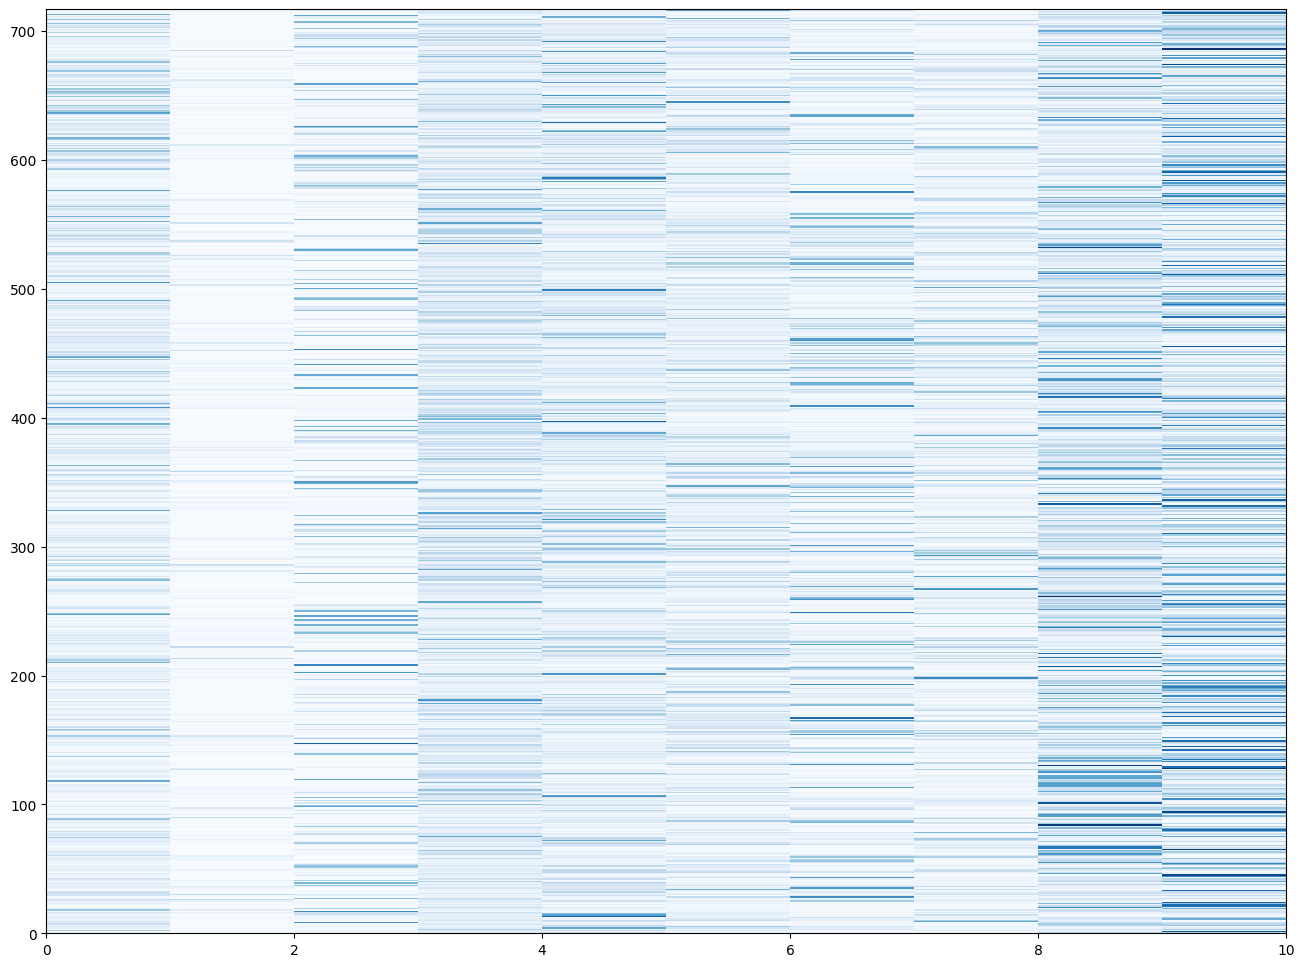

In [128]:
fig = plt.figure(figsize=(16, 12))
plt.pcolor(df_grouped.to_numpy(), norm=None, cmap='Blues')
plt.yticks(np.arange(df_grouped.to_numpy().shape[0])+0.5, [int(x) for x in df_grouped.index.values])
plt.xticks(np.arange(df_grouped.to_numpy().shape[1])+0.5, ["Topic #"+str(n) for n in range(lda.num_topics)], rotation = 45)
plt.colorbar(cmap='Blues')  # plot colorbar
plt.tight_layout()  # fixes margins
#plt.savefig("figures/nb2_topic_model_all_time_15.pdf")
plt.show()

In [57]:
topic_list = []
# Iterate over the topics
for k in range(lda.k):
    # Get the topic words
    topic_words = lda.get_topic_words(k)
    for word, prob in topic_words:
        topic_list.append({'topic': "Topic #{}".format(k), 'word': word, 'prob': prob})
topic_df = pd.DataFrame(topic_list)
# Set the topic column as the index
topic_df.set_index('topic', inplace=True)

In [65]:
read_lemma["date"]

0        2012-05-07
1        2012-05-07
2        2012-05-07
3        2012-05-07
4        2012-05-07
            ...    
25931    2022-08-16
25932    2022-08-16
25933    2022-08-16
25934    2022-08-16
25935    2022-08-16
Name: date, Length: 25936, dtype: object

In [67]:
import numpy as np 
before_2014 = np.array(read_lemma["date"] < '2014-01-01') 
after_2014 = ~ before_2014

## LDA 20 topics

In [ ]:
params = {'num_topics': 20, 'min_cf': 100, 'min_df': int(len(docs)*0.005), 'rm_top': 30, 'random_state': seed}

In [ ]:
lda = tp.LDAModel(k=params['num_topics'],min_cf=params['min_cf'],min_df=params['min_df'],seed=params['random_state'],rm_top=params['rm_top'])

In [ ]:
for doc in docs:
    lda.add_doc(doc)

for i in range(0, 1000, 10):
    lda.train(10)
    print('Iteration: {}\tLog-likelihood: {}'.format(i, lda.ll_per_word))

In [ ]:
for k in range(lda.k):
        print('Topic #{}'.format(k))
        for word, prob in lda.get_topic_words(k):
            print('\t', word, prob, sep='\t')

In [ ]:
print('Num docs:{}, Num Vocabs:{}, Total Words:{}'.format(
    len(lda.docs), len(lda.used_vocabs), lda.num_words
))

In [ ]:
print('Removed Top words: ', *lda.removed_top_words)

In [ ]:
lda.save('models/lda_tomotopy_20t.bin')

In [ ]:
lda = tp.LDAModel.load('models/lda_tomotopy_20t.bin')
for k in range(lda.k):
    #if not mdl.is_live_topic(k): continue
    print('Top 10 words of topic #{}'.format(k))
    print(lda.get_topic_words(k, top_n=10))

lda.load('models/lda_tomotopy_20t.bin')

In [ ]:
topic_term_dists = np.stack([lda.get_topic_word_dist(k) for k in range(lda.k)])

In [ ]:
doc_topic_dists = np.stack([doc.get_topic_dist() for doc in lda.docs])

In [ ]:
doc_topic_dists /= doc_topic_dists.sum(axis=1, keepdims=True)

In [ ]:
from collections import Counter
doc_lengths = np.array([len(doc.words) for doc in lda.docs])
counter = Counter(doc_lengths)

In [ ]:
vocab = list(lda.used_vocabs)
term_frequency = lda.used_vocab_freq

In [ ]:
pyLDAvis.enable_notebook()

In [ ]:
prepared_data = pyLDAvis.prepare(
    topic_term_dists, 
    doc_topic_dists, 
    doc_lengths, 
    vocab, 
    term_frequency,
    start_index=0, # tomotopy starts topic ids with 0, pyLDAvis with 1
    sort_topics=False # IMPORTANT: otherwise the topic_ids between pyLDAvis and tomotopy are not matching!
)

In [ ]:
prepared_data

In [ ]:
# calculate coherence using preset
for preset in ('u_mass', 'c_uci', 'c_npmi', 'c_v'):
    coh = tp.coherence.Coherence(lda, coherence=preset)
    average_coherence = coh.get_score()
    coherence_per_topic = [coh.get_score(topic_id=k) for k in range(lda.k)]
    print('==== Coherence : {} ===='.format(preset))
    print('Average:', average_coherence, '\nPer Topic:', coherence_per_topic)
    print()

## LDA 25 topics

In [ ]:
params = {'num_topics': 25, 'min_cf': 100, 'min_df': int(len(docs)*0.005), 'rm_top': 30, 'random_state': seed}

In [ ]:
lda = tp.LDAModel(k=params['num_topics'],min_cf=params['min_cf'],min_df=params['min_df'],seed=params['random_state'],rm_top=params['rm_top'])

In [ ]:
for doc in docs:
    lda.add_doc(doc)

for i in range(0, 1000, 10):
    lda.train(10)
    print('Iteration: {}\tLog-likelihood: {}'.format(i, lda.ll_per_word))

In [ ]:
for k in range(lda.k):
        print('Topic #{}'.format(k))
        for word, prob in lda.get_topic_words(k):
            print('\t', word, prob, sep='\t')

In [ ]:
print('Num docs:{}, Num Vocabs:{}, Total Words:{}'.format(
    len(lda.docs), len(lda.used_vocabs), lda.num_words
))

In [ ]:
print('Removed Top words: ', *lda.removed_top_words)

In [ ]:
lda.save('models/lda_tomotopy_25t.bin')

In [ ]:
lda = tp.LDAModel.load('models/lda_tomotopy_25t.bin')
for k in range(lda.k):
    #if not mdl.is_live_topic(k): continue
    print('Top 10 words of topic #{}'.format(k))
    print(lda.get_topic_words(k, top_n=10))

lda.load('models/lda_tomotopy_25t.bin')

In [ ]:
topic_term_dists = np.stack([lda.get_topic_word_dist(k) for k in range(lda.k)])

In [ ]:
doc_topic_dists = np.stack([doc.get_topic_dist() for doc in lda.docs])

In [ ]:
doc_topic_dists /= doc_topic_dists.sum(axis=1, keepdims=True)

In [ ]:
from collections import Counter
doc_lengths = np.array([len(doc.words) for doc in lda.docs])
counter = Counter(doc_lengths)

In [ ]:
vocab = list(lda.used_vocabs)
term_frequency = lda.used_vocab_freq

In [ ]:
pyLDAvis.enable_notebook()

In [ ]:
prepared_data = pyLDAvis.prepare(
    topic_term_dists, 
    doc_topic_dists, 
    doc_lengths, 
    vocab, 
    term_frequency,
    start_index=0, # tomotopy starts topic ids with 0, pyLDAvis with 1
    sort_topics=False # IMPORTANT: otherwise the topic_ids between pyLDAvis and tomotopy are not matching!
)

In [ ]:
prepared_data

In [ ]:
# calculate coherence using preset
for preset in ('u_mass', 'c_uci', 'c_npmi', 'c_v'):
    coh = tp.coherence.Coherence(lda, coherence=preset)
    average_coherence = coh.get_score()
    coherence_per_topic = [coh.get_score(topic_id=k) for k in range(lda.k)]
    print('==== Coherence : {} ===='.format(preset))
    print('Average:', average_coherence, '\nPer Topic:', coherence_per_topic)
    print()

## LDA gensim 10 topics

In [51]:
%%time

from gensim.models import LdaMulticore, LdaModel
params = {'num_topics': 10,'passes': 10, 'random_state': seed}

model = LdaModel(corpus=corpus, num_topics=params['num_topics'], id2word=dictionary, #workers=6,
                passes=params['passes'], random_state=params['random_state'])

CPU times: user 2min 10s, sys: 2.05 s, total: 2min 12s
Wall time: 2min 29s


In [52]:
model.show_topics(num_words=30, num_topics=params['num_topics'])

[(0,
  '0.014*"—Ç—ã—Å—è—á–∞" + 0.014*"–≤–æ–µ–Ω–Ω—ã–π" + 0.012*"—É—á–∞—Å—Ç–∏–µ" + 0.011*"—Ä–∞–±–æ—Ç–∞" + 0.010*"–ø—Ä–∏–Ω—è—Ç—å" + 0.009*"–æ—Ä—É–∂–∏–µ" + 0.009*"—Å–æ—Å—Ç–∞–≤" + 0.008*"—Ç–µ—Ö–Ω–∏–∫–∞" + 0.008*"–º–µ—Ä–æ–ø—Ä–∏—è—Ç–∏–µ" + 0.007*"–æ–±–æ—Ä–æ–Ω–∞" + 0.007*"–±–æ–µ–≤–æ–π" + 0.007*"—Å–æ–≤—Ä–µ–º–µ–Ω–Ω—ã–π" + 0.007*"–≤–æ–æ—Ä—É–∂–µ–Ω–∏–µ" + 0.007*"–ø—Ä–∏–Ω–∏–º–∞—Ç—å" + 0.007*"–º–∏–Ω–∏—Å—Ç–µ—Ä—Å—Ç–≤–æ" + 0.007*"—Ñ–ª–æ—Ç" + 0.006*"—Å–ª—É–∂–±–∞" + 0.006*"–∫–æ–Ω—Å—Ç–∏—Ç—É—Ü–∏—è" + 0.006*"–º–æ—Ä—Å–∫–æ–π" + 0.006*"–º–µ–¥–∏—Ü–∏–Ω—Å–∫–∏–π" + 0.006*"–∏–Ω—Ñ–µ–∫—Ü–∏—è" + 0.006*"—Ö–æ–¥" + 0.005*"–≤–æ–µ–Ω–Ω–æ" + 0.005*"–∑–∞–¥–∞—á–∞" + 0.005*"–ø–æ–¥–≥–æ—Ç–æ–≤–∫–∞" + 0.005*"–≤–æ–π—Å–∫–æ" + 0.005*"—Å–∏–ª–∞" + 0.005*"–æ–ø–µ—Ä–∞—Ü–∏—è" + 0.005*"—Å–ø–µ—Ü–∏–∞–ª—å–Ω—ã–π" + 0.005*"–¥–µ–ª–æ"'),
 (1,
  '0.027*"–±–µ–∑–æ–ø–∞—Å–Ω–æ—Å—Ç—å" + 0.014*"–±–æ—Ä—å–±–∞" + 0.013*"–ø—Ä–∞–≤–æ" + 0.012*"—É–≥—Ä–æ–∑–∞" + 0.011*"–æ—Ä–≥–∞–Ω" + 0.011*"–º–µ–∂–¥—É–Ω–∞—Ä–æ–¥–Ω—ã–π" + 0.010*"–≤–Ω–∏–º–∞–Ω–∏–µ" + 0.009*"—á–∏—Å–ª–æ" +

In [57]:
from imp import reload
import pyLDAvis
import pyLDAvis.gensim_models

pyLDAvis.enable_notebook()

In [59]:
# plot topics (NOTE: the IDs here do not match those from the model)
data =  pyLDAvis.gensim_models.prepare(model, corpus, dictionary, sort_topics=False)
pyLDAvis.display(data)

/opt/anaconda3/envs/nlp/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/anaconda3/envs/nlp/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/anaconda3/envs/nlp/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/anaconda3/envs/nlp/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


## Rhetoric Ratio Score